# California Housing Prices
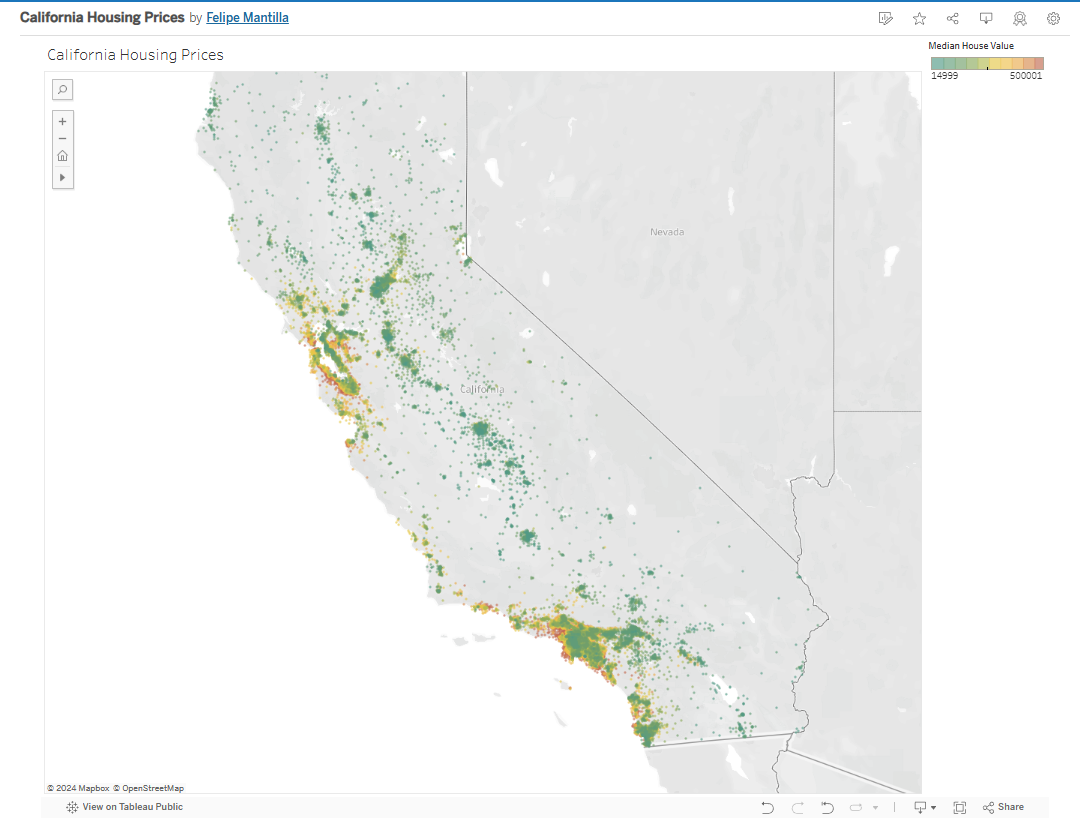

Link to tableau public: 
https://public.tableau.com/views/CaliforniaHousingPrices_17169037313240/Sheet1?:language=en-GB&:sid=&:display_count=n&:origin=viz_share_link


In [1]:
#Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.svm import SVC

# Frame the problem

### Housing Prices

California Housing Prices dataset from StatLib repository. It's not exactly recent to 2024 but its for learning pruposes. The model should learn from this data and be able to predict the median housing price in any district, given all the other metrics.

### Load the data

In [2]:
df = pd.read_csv('datasets/housing.csv')

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


It's a typical supervised learning since you are given labeled examples in column 'median_house_value'. Regression task since we have to predict a value. The performance measure for this model would be RMSE (root median square error). 

### Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


note that there are 20,640 instances but the column `total_bedroom` has 20,433. that means there are 207 missing values. All attributes are numerical, except the `ocean_proximity` column.

In [5]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

this columns is a categorical attribute by their repetitive values.

In [6]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

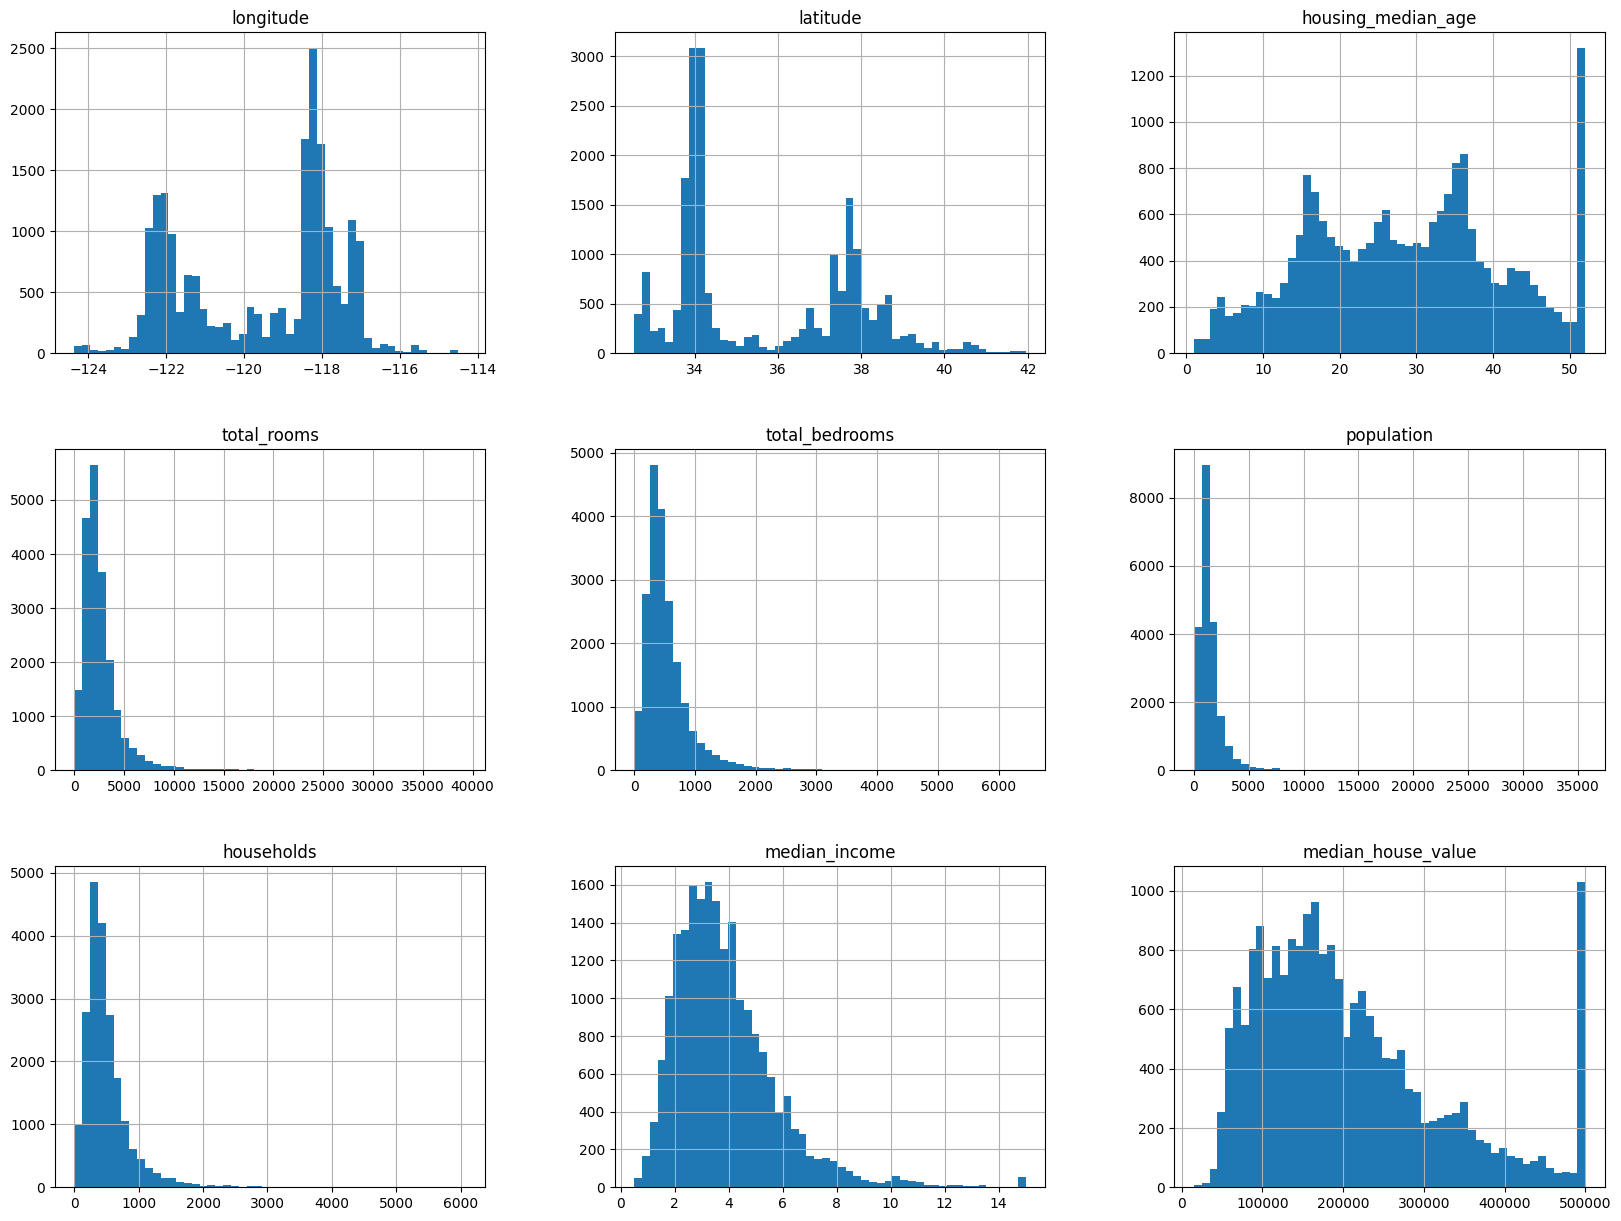

In [7]:
df.hist(bins=50, figsize=(20,15))

#### some notes

1. The median income has been scaled. The numbers represent tens of thousands of dollars. e.g., 3 means $30,000.
   
3. Housing median age and median house value were capped. So the ML algorithms may learn that the price never go beyond that limite ($500,000). In this case you have two options: 
    * collect proper labels for whose labels were capped.
    *  remove those districts.
    
4. These attributes have very different scales.
5. Many histograms are tail heavy. This may make it a bit harder for some ML algorithms to detect patterns.

### create test set

In [8]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state = 42)

In [9]:
df['income_cat'] = pd.cut(df['median_income'],
                          bins = [0.,1.5,3.0,4.5,6.,np.inf],
                          labels = [1,2,3,4,5])

<Axes: >

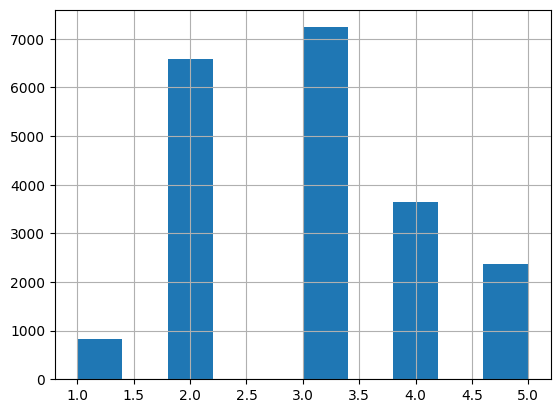

In [10]:
df['income_cat'].hist()

In [11]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index,test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [12]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

to obtain a test_set more similar to the distribution of the complete dataset instead of using random split, we use stratified sampling taking into account the values of the `average_income` column.

In [13]:
#remove the income_cat attribute (original)

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Discover and Visualize the data to Gain Insights

In [14]:
housing = strat_train_set.copy()

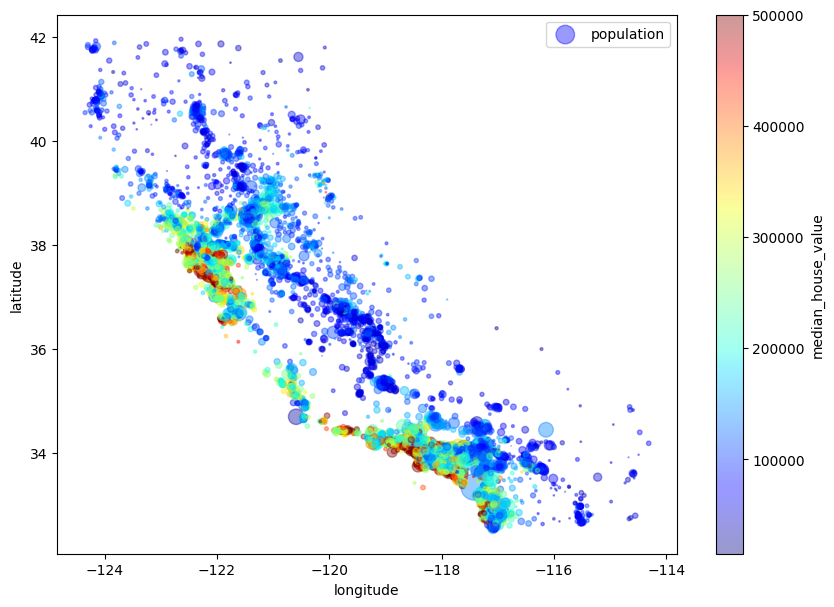

In [15]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=housing["population"]/100, label="population", figsize=(10,7),
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

This immage tells that the housing prices are very much related to the location like 'close to the ocean' and to the population density

#### looking for correlations

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

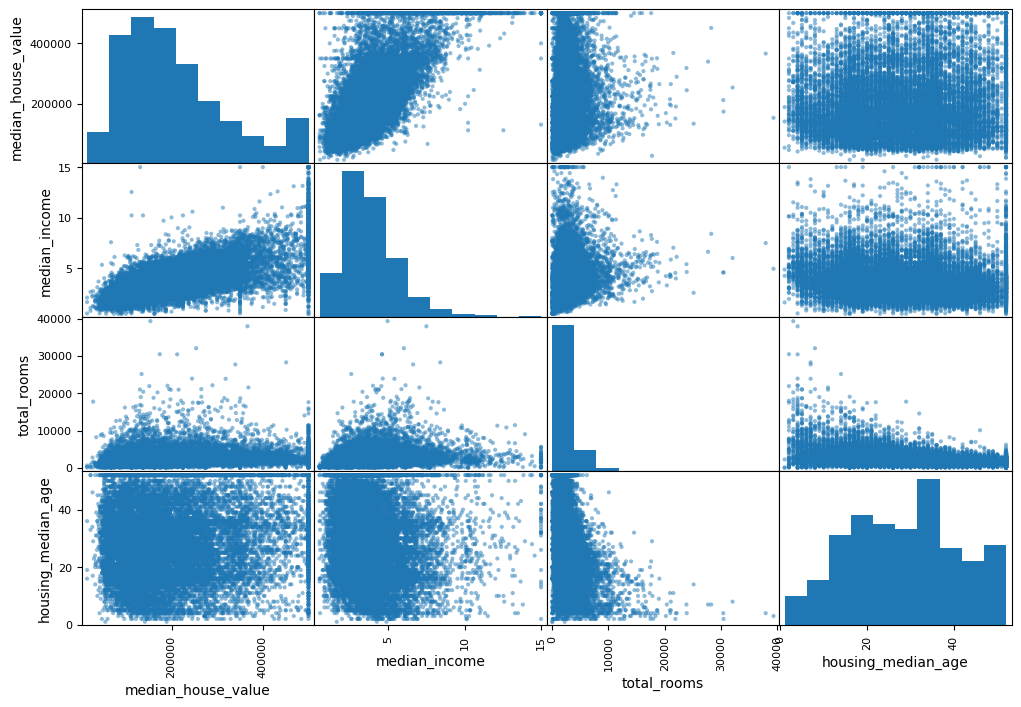

In [16]:
attributes = ["median_house_value", "median_income", "total_rooms", 
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

The most promising attribute to predict the median house value is the median
income, so let’s zoom in on their correlation scatterplot

<Axes: xlabel='median_income', ylabel='median_house_value'>

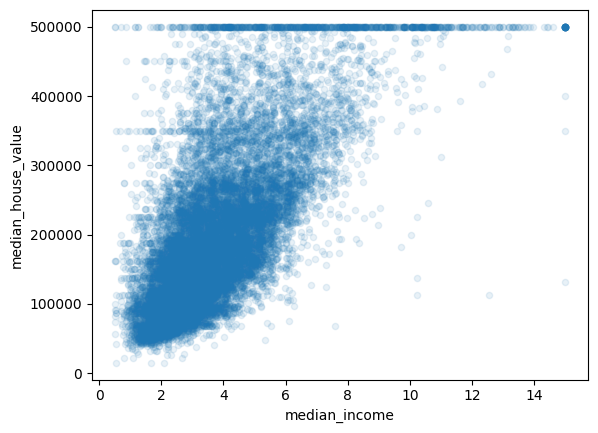

In [17]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",alpha=0.1)

In [18]:
# Experimenting with Attribute Combinations

housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]


array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='rooms_per_household', ylabel='median_house_value'>,
        <Axes: xlabel='bedrooms_per_room', ylabel='median_house_value'>,
        <Axes: xlabel='population_per_household', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='rooms_per_household'>,
        <Axes: xlabel='rooms_per_household', ylabel='rooms_per_household'>,
        <Axes: xlabel='bedrooms_per_room', ylabel='rooms_per_household'>,
        <Axes: xlabel='population_per_household', ylabel='rooms_per_household'>],
       [<Axes: xlabel='median_house_value', ylabel='bedrooms_per_room'>,
        <Axes: xlabel='rooms_per_household', ylabel='bedrooms_per_room'>,
        <Axes: xlabel='bedrooms_per_room', ylabel='bedrooms_per_room'>,
        <Axes: xlabel='population_per_household', ylabel='bedrooms_per_room'>],
       [<Axes: xlabel='median_house_value', ylabel='population_per_household'>,
        <Ax

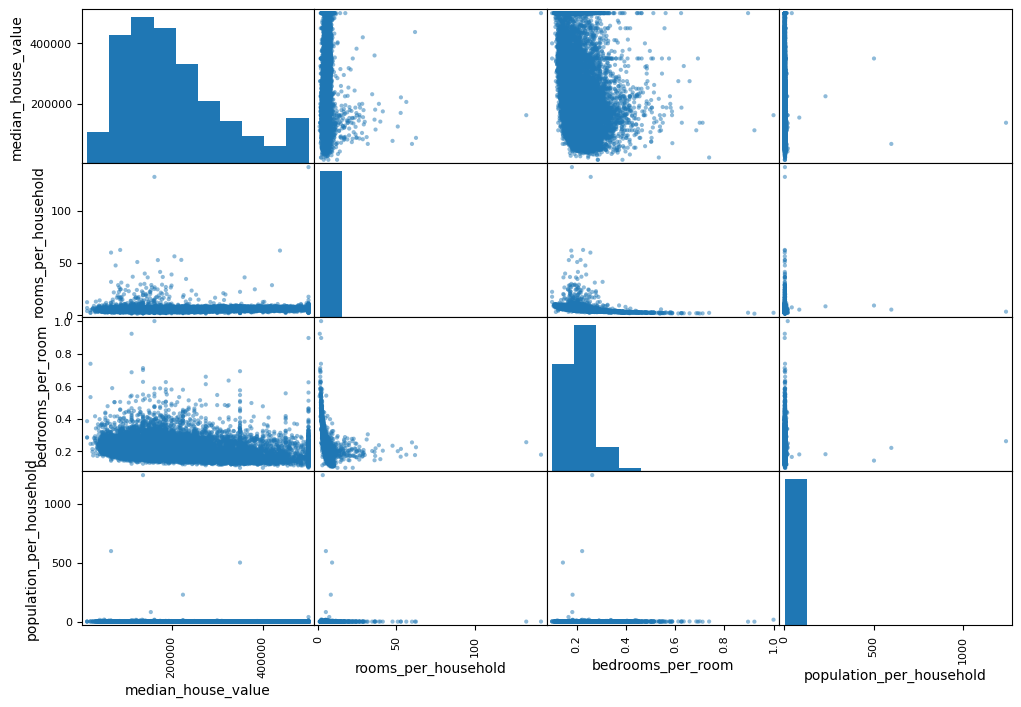

In [19]:
attributes = ["median_house_value", "rooms_per_household","bedrooms_per_room",
              "population_per_household"]
scatter_matrix(housing[attributes], figsize=(12, 8))

Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are.

### Data Cleaning

In [20]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [21]:
#using SimpleImputer fore handle missing values

imputer = SimpleImputer(strategy = 'median')

In [22]:
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [23]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [24]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [25]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

#### Handling Text and Cat attributes

In [26]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [27]:
ordinal_encoder = OrdinalEncoder()

In [28]:
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [29]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that two nearby
values are more similar than two distant values. This may be fine in some cases (e.g.,
for ordered categories such as “bad”, “average”, “good”, “excellent”), but it is obviously
not the case for the ocean_proximity column

In [30]:
cat_encoder = OneHotEncoder()

To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is “<1H OCEAN” (and 0 otherwise) and so on. This is called *one-hot encoding*

In [31]:
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
            bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### Feature Scaling

Two options: MinMaxScaler or Standardization

MinMaxScaler is ideal for data with non-normal distributions or when a specific range is needed, while StandardScaler is better when the data is normally distributed.

In [33]:
num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy = 'median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

In [34]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

So far, we have handled the categorical columns and the numerical columns separately. It would be more convenient to have a single transformer able to handle all columns

In [35]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

In [36]:
housing_prepared = full_pipeline.fit_transform(housing)

First, import the *ColumnTransformer* class. Then, get the lists of numerical and categorical column names. Construct a *ColumnTransformer* with tuples specifying a name, a transformer, and the columns to apply it to. Numerical columns use a previously defined *num_pipeline*, and categorical columns use a *OneHotEncoder*. Finally, apply the *ColumnTransformer* to the data, transforming each column appropriately and concatenating the outputs.

### Select and Train a Model

In [37]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [38]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

In [39]:
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


In [40]:
print('labels: ', list(some_labels))

labels:  [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [41]:
#RMSE on whole training set

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

This is not a great score and an example of a model underfitting the training data. To fix this we could select a more powerful model. Let's try with *DecisionTreeRegressor*. This is a good choise when you need find complex nonlinear relationships. 

In [42]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [43]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Now it looks like the model overfit the data. Let's use a cross validation 

In [44]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [45]:
def display_scores(scores):
    print('Scores: ',scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores:  [73753.2598872  71263.48782178 69771.91284532 71117.46891517
 70218.14171538 78162.29513437 71363.51190248 72523.63447707
 69953.42517648 72267.84501628]
Mean: 72039.49828915359
Standard deviation: 2354.4091116703084


These scores show the decision tree model is overfitting. Lets try with *RandomForestRegressor* 

In [46]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [47]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(tree_mse)
forest_rmse

0.0

In [48]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

In [49]:
display_scores(forest_rmse_scores)

Scores:  [51283.42711647 48974.82482934 47021.12973301 51964.04308761
 47674.92077291 51410.74042525 52735.86238085 49867.46975071
 48361.08042095 54295.20781055]
Mean: 50358.87063276612
Standard deviation: 2239.9771877581234


The scores show that the model still overfitting the training set. Possible solutions for overfitting are to simplify the model, constrain it or get a lot more training data. 

In [50]:
#Applying Grid Search

param_grid = [
    {'n_estimators': [30, 50, 80], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10],
     'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [30, 50, 80]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [51]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=80)

In [52]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"],
                              cvres["params"]):
    print(np.sqrt(-mean_score), params)

52424.066700280506 {'max_features': 2, 'n_estimators': 30}
52342.24288156049 {'max_features': 2, 'n_estimators': 50}
51804.81061843026 {'max_features': 2, 'n_estimators': 80}
50401.47482956783 {'max_features': 4, 'n_estimators': 30}
49909.8999527107 {'max_features': 4, 'n_estimators': 50}
49702.19682042835 {'max_features': 4, 'n_estimators': 80}
49947.08532153503 {'max_features': 6, 'n_estimators': 30}
49587.183091295024 {'max_features': 6, 'n_estimators': 50}
49485.28815324386 {'max_features': 6, 'n_estimators': 80}
50380.679007113424 {'max_features': 8, 'n_estimators': 30}
49542.74600129804 {'max_features': 8, 'n_estimators': 50}
49348.155420904084 {'max_features': 8, 'n_estimators': 80}
62631.770297632145 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54375.29005585207 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60989.27912979458 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52684.16076703988 {'bootstrap': False, 'max_features': 3, 'n_estimat

The best combination for this model has a score of  49309.2378203841 {'max_features': 6, 'n_estimators': 80} which is slightly better than the other score

#### Analyze the Best Models and Their Errors

In [53]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.90063029e-02, 6.29400343e-02, 4.34248128e-02, 1.51630189e-02,
       1.51455264e-02, 1.52650073e-02, 1.45122344e-02, 3.84109008e-01,
       4.82488685e-02, 1.11209274e-01, 5.95545022e-02, 6.99849218e-03,
       1.48316804e-01, 7.17177096e-05, 2.15730052e-03, 3.87709681e-03])

In [54]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3841090078660869, 'median_income'),
 (0.1483168036563508, 'INLAND'),
 (0.11120927373803524, 'pop_per_hhold'),
 (0.06900630287939204, 'longitude'),
 (0.06294003434597426, 'latitude'),
 (0.05955450215732907, 'bedrooms_per_room'),
 (0.04824886848200852, 'rooms_per_hhold'),
 (0.043424812751487255, 'housing_median_age'),
 (0.01526500730230009, 'population'),
 (0.015163018885217216, 'total_rooms'),
 (0.015145526370026429, 'total_bedrooms'),
 (0.014512234356029196, 'households'),
 (0.006998492178236543, '<1H OCEAN'),
 (0.003877096806554409, 'NEAR OCEAN'),
 (0.002157300515336081, 'NEAR BAY'),
 (7.171770963605064e-05, 'ISLAND')]

apparently only ocean_proximity category is really useful. 

In [55]:
# Evaluate Your System on the Test Set

final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [56]:
final_rmse

47258.335465225355

In [57]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45289.22443259, 49148.61841581])

### testing a Support Vector Machine

In [59]:
svm = SVC(kernel='linear')
svm.fit(housing_prepared, housing_labels)

SVC(kernel='linear')

In [60]:
housing_predictions = svm.predict(housing_prepared)

In [61]:
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(tree_mse)
svm_rmse

0.0

In [63]:
scores = cross_val_score(svm, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error")
svm_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

KeyboardInterrupt



_Due to the hardware capacity of my computer, I will stop this notebook here. However, some additional tests can be done to improve the score on the test set and generalize the data better. These tests include trying different kernels and hyperparameters in the SVC regressor and reducing the features to only the most important attributes._ 